# CQF - Final Project

## Optimal Hedging with Advanced Greeks

### Imports

In [185]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
from statistics import mean
from scipy.stats.mstats import gmean
import matplotlib.pyplot as plt
%matplotlib inline

### Simple Volatility Arbitrage but improved Asset Evolution

We will use the geometric Brownian motion (GBM), thus this mens the stock price follows a random walk and is consistent with the weak form of the efficient market hypothesis (EMH) - past price information is already incorporated, and the next price movement is "conditionally independent" of past price movements.

The formula for GBM is found below:

$$
\Delta S = S \mu \delta t + S \sigma \epsilon \sqrt{\Delta t}
$$

**where:**

$$
\begin{align*}
S &= \text{the stock price} \\
\Delta S &= \text{the change in stock price} \\
\mu &= \text{the expected return} \\
\sigma &= \text{the standard deviation of returns} \\
\epsilon &= \text{the random variable} \\
\Delta t &= \text{the elapsed time period} \\
\end{align*}

### Variance Reduction

In order to get a realistic comparison we will fixed the seed value for random number generator 

In [186]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * 10000)
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
 0.001150944833  1.006296354600
 0.002841204001  0.995987967146
 0.001998082016  0.997701714233
 0.001322322067  0.997771186968
 0.000592711311  0.998388962646
-0.000339730751  0.998399891450
-0.000228109010  0.998657429396
 0.000295768719  0.998877333340
 0.000257107789  0.999284894532
-0.000357870642  0.999456401088
-0.000528443742  0.999617831131
-0.000300171536  0.999445228838
-0.000162924037  0.999516059328
 0.000135778889  0.999611052522
 0.000182006048  0.999619405229


The result shows that the statistics get better the larger the sample size. However it does not still match.

The *antithetic variates* technic consists in draws only half the desired number of random draws, and adds the same set of random numbers with the opposite sign afterward. The described method works for sysmmetric median 0 random variables only, like standard normally distributed random variables, which are almost exclusively used throughout. 

In [187]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * int(10000 / 2))
    sn = np.concatenate((sn, -sn))
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
-0.000000000000  1.017474904235
 0.000000000000  0.998944776883
 0.000000000000  0.998018870658
 0.000000000000  0.997916558845
-0.000000000000  0.998119811838
 0.000000000000  0.998365584578
 0.000000000000  0.998171301115
-0.000000000000  0.998359568664
-0.000000000000  0.998772594780
-0.000000000000  0.998640403762
 0.000000000000  0.998868127277
 0.000000000000  0.999102053335
 0.000000000000  0.999342143561
 0.000000000000  0.999449673443
-0.000000000000  0.999613960655


This results in a mean value of zero, even in smaller sample sizes.

In [188]:
def next_corputSequence(n, base=2):
    n1 = n
    c = 0
    ib = 1.0 / base
    while n1 > 0:
        n2 = int(n1 / base)
        i = n1 - n2 * base
        c = c + ib * i
        ib = ib / base
        n1 = n2
    return c

In [189]:
[next_corputSequence(i, base=2) for i in range(0, 16)]

[0,
 0.5,
 0.25,
 0.75,
 0.125,
 0.625,
 0.375,
 0.875,
 0.0625,
 0.5625,
 0.3125,
 0.8125,
 0.1875,
 0.6875,
 0.4375,
 0.9375]

In [190]:
from scipy.stats import qmc

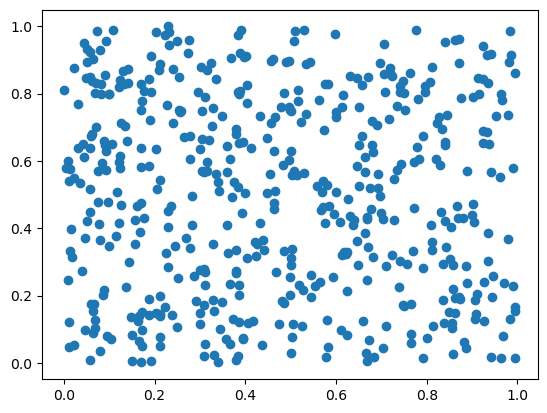

In [191]:
plt.scatter(x=np.random.rand(2**9), y=np.random.rand(2**9))

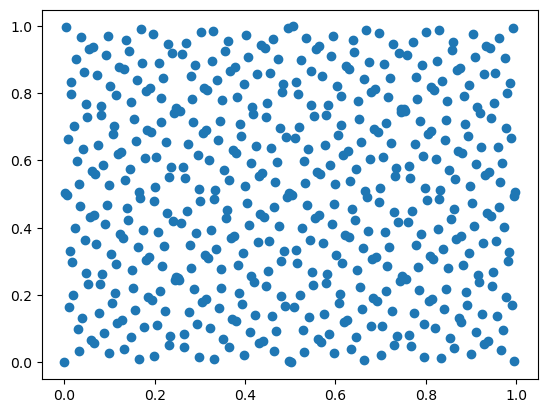

In [192]:
sampler = qmc.Sobol(d=2, scramble=False)
sample_sequence = sampler.random_base2(m=9)
plt.scatter(x=sample_sequence[:,0], y=sample_sequence[:,1])

Define the Black Scholes Merton close formula to solve an European Call

In [193]:
def BlackScholesMerton(S0, K, r, div, sigma, T):
    h1 = (np.log(S0 / K) + ((r - div) + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    h2 = h1 - sigma * np.sqrt(T)
    return S0 * np.exp(-div * T) * norm.cdf(h1) - K * np.exp(-r * T) * norm.cdf(h2)

Defining the parameters

In [195]:
S0 = 20.0 # pot at time zero
K = 20.0 # option strike
T = 2.0 # time to expiry
r = 0.08 # risk free rate
div = 0.08 # dividend yield
sigma = 0.25 # volatility

The exact solution

In [167]:
exact_soluction = BlackScholesMerton(S0=S0, K=K, r=r, div=div, sigma=sigma, T=T)
exact_soluction

2.3913916482553503

In [202]:
def van_der_corput_sequence(base, i):
    n1 = i
    c = 0
    ib = 1 / base
    while n1 > 0:
        n2 = int(n1 / base)
        diff = n1 - n2 * base
        c = c + ib * diff
        ib = ib / base
        n1 = n2
    return c

def sobol_sequence(i):
    return van_der_corput_sequence(base=2, i=i)

def sobol_sequenceN(N):
    return [van_der_corput_sequence(base=2, i=i) for i in range(0, N)]

In [200]:
n_simul = 20000
trend = (r-div-0.5*sigma**2)*T

mc = np.exp(-r*T)*np.mean([max(s-K,0) for s in S0 * np.exp(trend + np.random.randn(n_simul)*np.sqrt(T)*sigma)])
qmc = np.exp(-r*T)*np.mean([max(S0 * np.exp(trend + sigma*np.sqrt(T)*norm.ppf(sobol_sequence(i))) - K, 0) for i in range(1, n_simul + 1)])

[exact_soluction, mc, qmc]

[2.3913916482553503, 2.369378897629428, 2.387697194251352]

In [212]:
np.exp(-r*T)*np.mean([max(S0 * np.exp(trend + sigma*np.sqrt(T)*norm.ppf(i)) - K, 0) for i in sobol_sequenceN(n_simul)])

2.387697194251352

In [171]:
S0 = 100.0
T = 1.0
sigma_a = 0.35
sigma_i = 0.20
r = 0.02
N = 200
dt = T / N
ts = np.arange(0, T, dt)
dB = np.concatenate((np.zeros(1), np.random.randn(N-1)*np.sqrt(dt)))
B = np.cumsum(dB)

In [214]:
unif = sobol_sequenceN(100)
unif

[0,
 0.5,
 0.25,
 0.75,
 0.125,
 0.625,
 0.375,
 0.875,
 0.0625,
 0.5625,
 0.3125,
 0.8125,
 0.1875,
 0.6875,
 0.4375,
 0.9375,
 0.03125,
 0.53125,
 0.28125,
 0.78125,
 0.15625,
 0.65625,
 0.40625,
 0.90625,
 0.09375,
 0.59375,
 0.34375,
 0.84375,
 0.21875,
 0.71875,
 0.46875,
 0.96875,
 0.015625,
 0.515625,
 0.265625,
 0.765625,
 0.140625,
 0.640625,
 0.390625,
 0.890625,
 0.078125,
 0.578125,
 0.328125,
 0.828125,
 0.203125,
 0.703125,
 0.453125,
 0.953125,
 0.046875,
 0.546875,
 0.296875,
 0.796875,
 0.171875,
 0.671875,
 0.421875,
 0.921875,
 0.109375,
 0.609375,
 0.359375,
 0.859375,
 0.234375,
 0.734375,
 0.484375,
 0.984375,
 0.0078125,
 0.5078125,
 0.2578125,
 0.7578125,
 0.1328125,
 0.6328125,
 0.3828125,
 0.8828125,
 0.0703125,
 0.5703125,
 0.3203125,
 0.8203125,
 0.1953125,
 0.6953125,
 0.4453125,
 0.9453125,
 0.0390625,
 0.5390625,
 0.2890625,
 0.7890625,
 0.1640625,
 0.6640625,
 0.4140625,
 0.9140625,
 0.1015625,
 0.6015625,
 0.3515625,
 0.8515625,
 0.2265625,
 0.7265625,


In [174]:
df = pd.DataFrame(data=ts, columns=['Time'])

,Time
0,0.000
1,0.005
2,0.010
3,0.015
4,0.020
...,...
195,0.975
196,0.980
197,0.985
198,0.990


## References
- [Investopedia - Monte Carlo](https://www.investopedia.com/articles/07/montecarlo.asp)
- HILPISCH, Yves. **Python for Finance: Mastering Data-driven Finance**. 2. ed. O'Reilly Media, 2019.
- Galanti & Jung: "Low-Discrepancy Sequences: Monte Carlo Simulation of Option Prices", Journal of Derivatives, Fall 1997, pp.63-83.